<a href="https://colab.research.google.com/github/ShahedSabab/Fake-or-Not/blob/master/fakeorNotfake_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Sat Feb 29 22:04:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |   4391MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install tensorflow-gpu >> /dev/null
!pip install tqdm >> /dev/null
!pip install bert-for-tf2 >> /dev/null
!pip install sentencepiece >> /dev/null

In [0]:
import os
import math
import datetime
from tqdm import tqdm 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import regularizers

import bert 
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
import seaborn as sns

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [0]:
!gdown --id 10GbJ0KV9FLxiqYHiyKKLSsCDtdMOINMk --output data_train.csv

Downloading...
From: https://drive.google.com/uc?id=10GbJ0KV9FLxiqYHiyKKLSsCDtdMOINMk
To: /content/data_train.csv
100% 803k/803k [00:00<00:00, 109MB/s]


In [0]:
RANDOM_SEED = 42
lr = 0.000010
max_seq_len = 128
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
train_frac = 0.8

df = pd.read_csv("data_train.csv")
df = df.sample(frac=1)
train = df.sample(frac=train_frac)
test = df[~df.isin(train)].dropna()
train.shape


(6090, 2)

Text(0.5, 1.0, 'Number of examples per category')

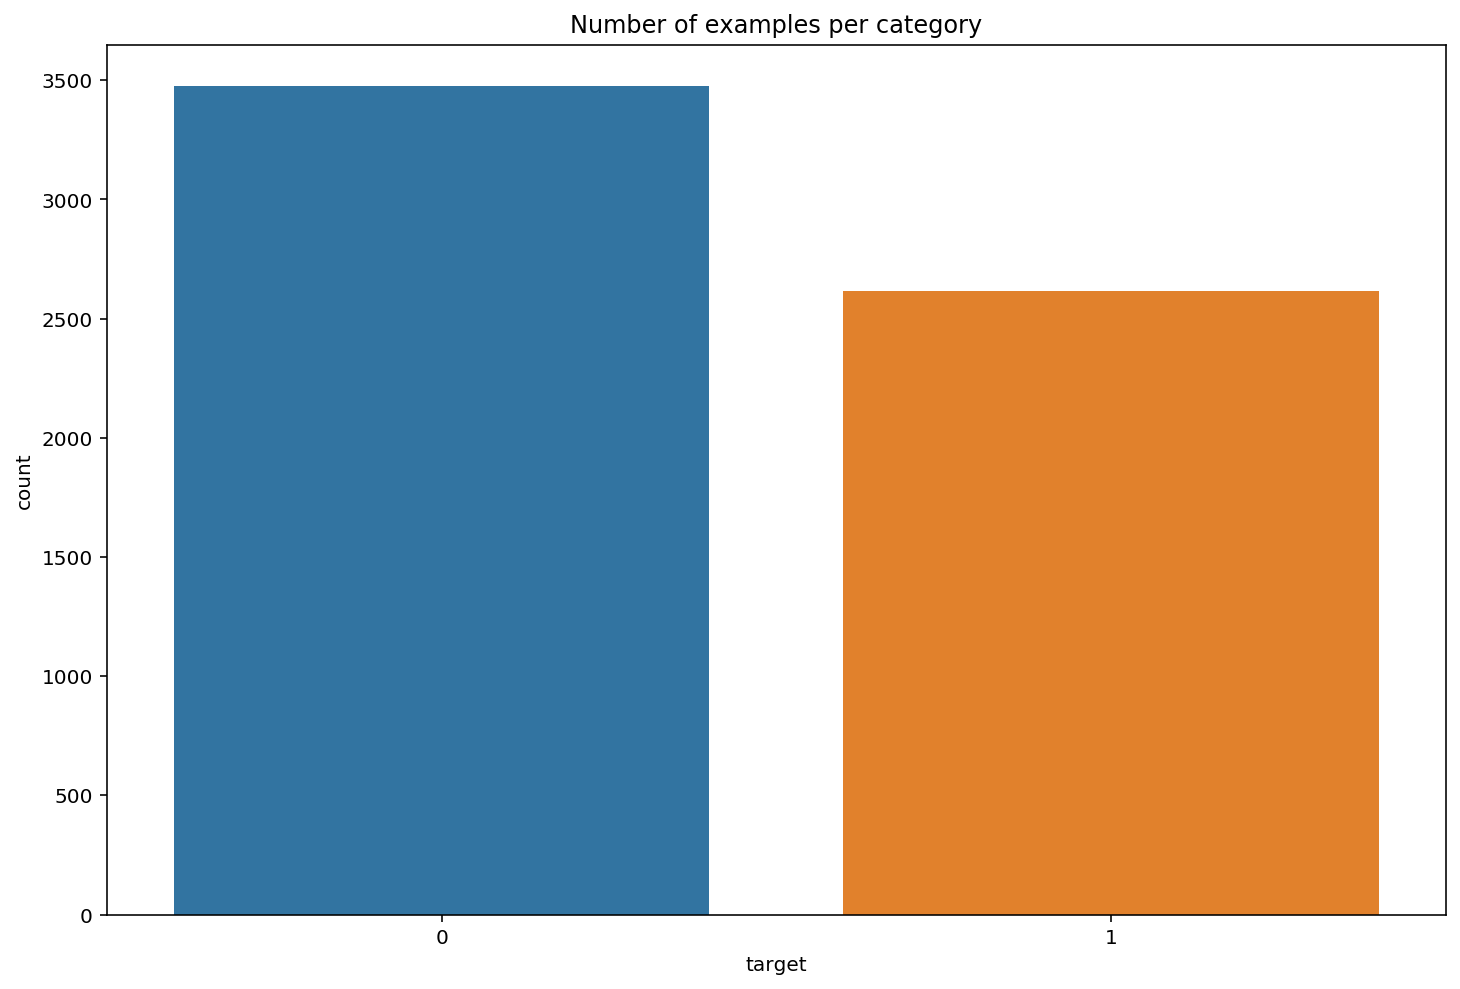

In [0]:
rcParams['figure.figsize'] = 12,8
chart = sns.countplot(train.target)
plt.title("Number of examples per category")

In [0]:
 !wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
 !unzip uncased_L-12_H-768_A-12.zip
 os.makedirs('model', exist_ok = True)
 !mv uncased_L-12_H-768_A-12/ model

--2020-02-29 22:04:42--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.2’

uncased_L-12_H-768_ 100%[===================>] 388.84M   187MB/s    in 2.1s    

2020-02-29 22:04:45 (187 MB/s) - ‘uncased_L-12_H-768_A-12.zip.2’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
replace uncased_L-12_H-768_A-12/bert_model.ckpt.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
mv: cannot move 'uncased_L-12_H-768_A-12/' to 'model/uncased_L-12_H-768_A-12': Directory not empty


In [0]:
#bert pretrained model weights and configuration file
bert_model_name = 'uncased_L-12_H-768_A-12'
bert_ckpt_dir = os.path.join('model/', bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')
bert_config_file = os.path.join(bert_ckpt_dir, 'bert_config.json')
tokenizer = FullTokenizer(vocab_file= os.path.join(bert_ckpt_dir, 'vocab.txt'))

In [0]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "target"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)


def create_model(max_seq_len, bert_config_file, bert_ckpt_file):
    with tf.io.gfile.GFile(bert_config_file, 'r') as reader:
        bc = StockBertConfig.from_json_string(reader.read())
    bert_params = map_stock_config_to_params(bc)
    bert_params.adapter_size = None
    bert = BertModelLayer.from_params(bert_params, name = 'bert')
    
    input_ids = keras.layers.Input(shape = (max_seq_len, ), dtype='int32', name='input_ids')
    bert_output = bert(input_ids)
    
    print('bert_shape', bert_output.shape)
    
    cls_out = keras.layers.Lambda(lambda seq: seq[:,0,:]) (bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation='relu', kernel_regularizer = regularizers.l1 (0.001) )(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(1)(logits)
    
    model = keras.Model(inputs = input_ids, outputs= logits)
    model.build(input_shape=(None, max_seq_len))
    
    load_stock_weights(bert, bert_ckpt_file)
    
    return model

def plot_graphs(f, history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [35]:
classes = train.target.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=max_seq_len)
model = create_model(data.max_seq_len, bert_config_file, bert_ckpt_file)

model.summary()

model.compile(
    optimizer = keras.optimizers.Adam(lr),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

6090it [00:02, 2325.14it/s]
1523it [00:00, 2415.12it/s]


max seq_len 84
bert_shape (None, 84, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1fa1ebe358> (prefix:bert_3). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 84)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 

Train on 4872 samples, validate on 1218 samples
Epoch 1/5
4872/4872 [==============================] - 223s 46ms/sample - loss: 18.2103 - accuracy: 0.7133 - val_loss: 17.3253 - val_accuracy: 0.8153
Epoch 2/5
4872/4872 [==============================] - 212s 43ms/sample - loss: 16.5302 - accuracy: 0.8397 - val_loss: 15.7794 - val_accuracy: 0.8153
Epoch 3/5
4872/4872 [==============================] - 211s 43ms/sample - loss: 14.9093 - accuracy: 0.8742 - val_loss: 14.2788 - val_accuracy: 0.8062
Epoch 4/5
4872/4872 [==============================] - 210s 43ms/sample - loss: 13.3248 - accuracy: 0.9048 - val_loss: 12.7831 - val_accuracy: 0.8112
Epoch 5/5
4872/4872 [==============================] - 210s 43ms/sample - loss: 11.7886 - accuracy: 0.9337 - val_loss: 11.3630 - val_accuracy: 0.8186


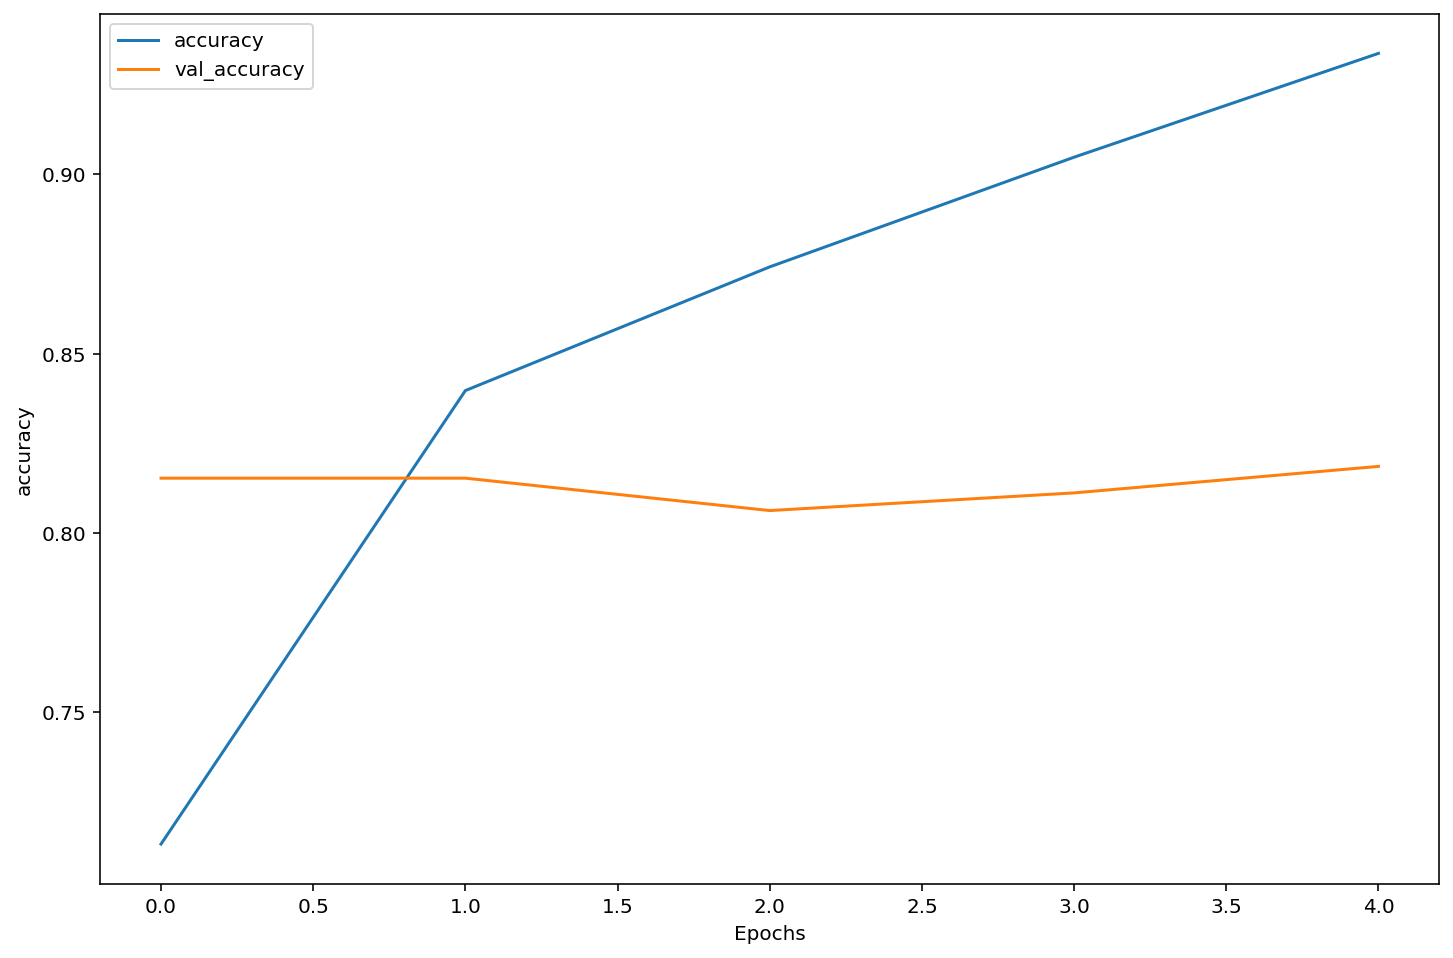

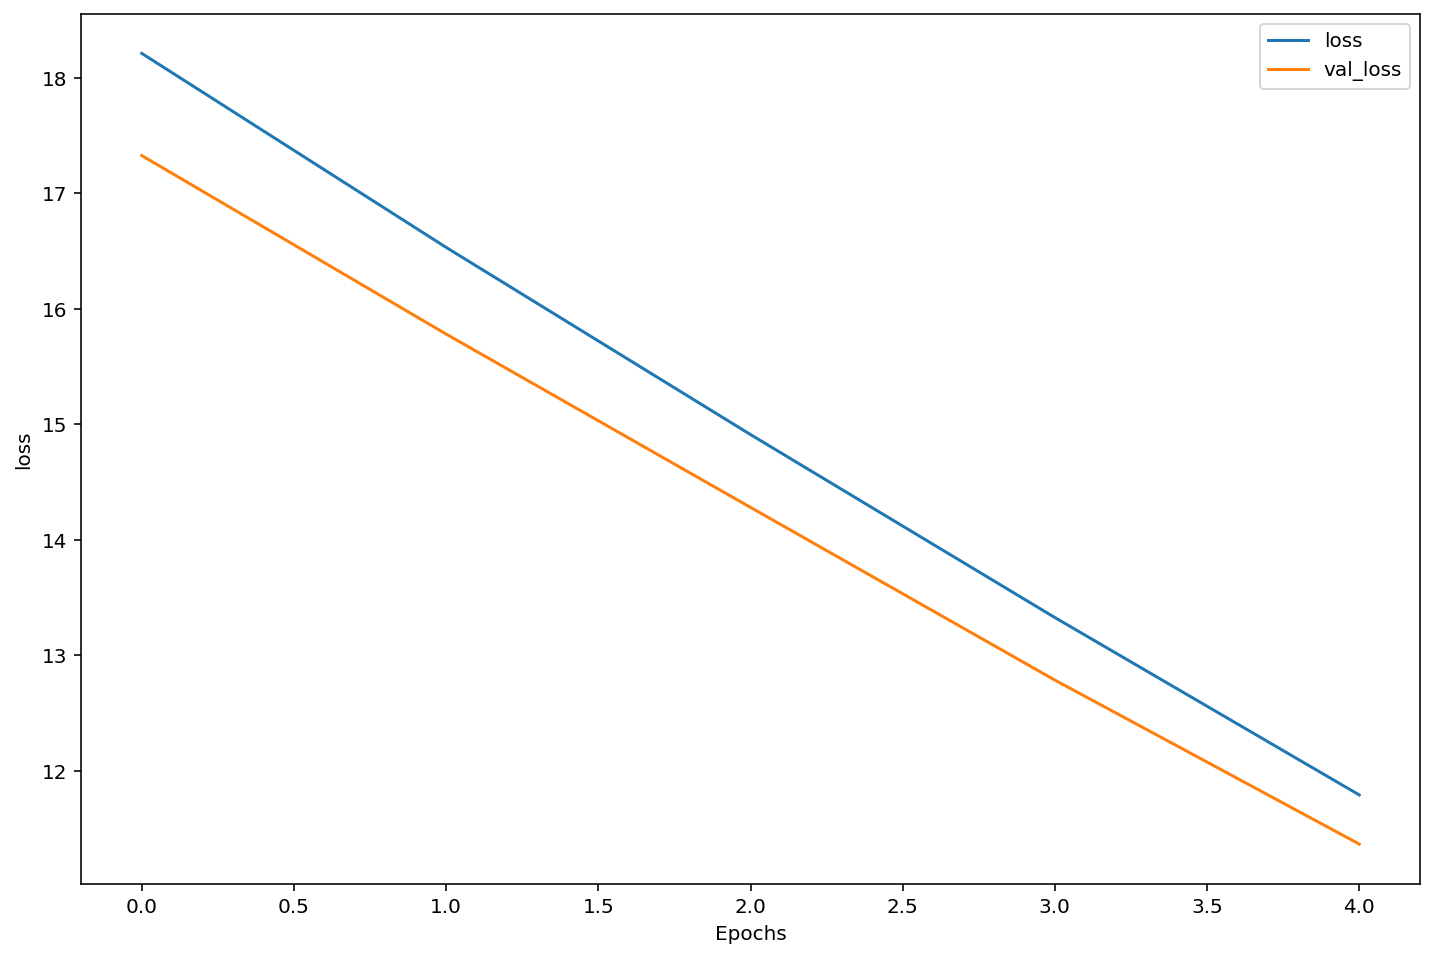

1523/1523 - 10s - loss: 11.3473 - accuracy: 0.8450
Test, accuracy: 84.50%


In [36]:
history = model.fit(
    x = data.train_x,
    y = data.train_y,
    validation_split = 0.2,
    batch_size = 8,
    verbose =1 ,
    shuffle = True,
    epochs = 5
#    callbacks=[tensorboard_callback]
)
#
f1 = plt.figure()
plot_graphs(f1,history, "accuracy")
f2 = plt.figure()
plot_graphs(f2,history, "loss")

#

#_, test_acc = model.evaluate(data.test_x, data.test_y)
#y_pred = model.predict(data.test_x).argmax(axis=-1)
#print(classification_report(data.test_y, y_pred, target_names = classes))

# Evaluate the model
loss, acc = model.evaluate(data.test_x,  data.test_y, verbose=2)
print("Test, accuracy: {:5.2f}%".format(100*acc))
